# 대회 개요

[대회 설명]
- 시간이 지남에 따라 고객 주문에 대한 익명화된 데이터를 사용하여 이전에 구매한 제품이 사용자의 다음 주문에 있을지 예측하는 최고의 모델을 찾는 대회

  즉, **대회의 목표는 어떤 제품이 사용자의 다음 주문에 있을지 예측하는 것**.
- [Kaggle Competition Page](https://www.kaggle.com/competitions/instacart-market-basket-analysis)

# 데이터 개요

[데이터 설명]
- 이 데이터셋은 **시간**에 따른 **고객 주문**을 설명하는 csv 파일들로 구성되어 있습니다.
- 이 데이터는 사용자가 **어떤 물품을 다시 주문할지 예측**하는 문제를 풀어야 합니다.
- 데이터셋은 **익명화**되어 있으며 20만 명이 넘는 instacart 사용자의 300만건 이상의 주문들을 포함하고 있습니다.
- 각 사용자별로, 4회에서 100회 사이의 주문 데이터가 제공됩니다. 또한 주문이 이루어진 주와 시간, 그리고 주문 간의 상대적인 시간을 제공합니다.
- 데이터 파일은 6개로 구성되어 있으며, 각 csv 파일에 대한 설명은 다음과 같습니다.

[csv별 설명]
1. orders.csv
    - order_id: 주문 식별자
    - user_id: 고객 식별자
    - eval_set: 주문이 속한 evaluation set
    - order_number: 고객의 주문 번호 (1 = 첫 번째, n = n번째)
    - order_dow: 주문한 요일
    - order_hour_of_day: 주문이 이루어진 날의 시간
    - days_since_prior: 마지막 주문 이후 일수, 30일로 제한(주문 번호 = 1의 경우 NA)

2. products.csv
    - product_id: 제품 식별자
    - product_name: 제품명
    - aisle_id: 제품 중분류 식별자
    - department_id: 제품 대분류 식별자

3. aisles.csv
    - aisle_id: 제품 중분류 식별자
    - aisle: 제품 중분류 명

4. deptartments.csv
    - department_id: 제품 대분류 식별자
    - department: 제품 대분류 명

5. order_products__SET.csv
    - order_id: 주문 식별자
    - product_id: 제품 식별자
    - add_to_cart_order:  각 제품이 장바구니에 추가된 순서
    - reordered: 제품이 과거에 해당 고객에 의해 주문된 경우 1, 그렇지 않으면 0

    - 여기서 SET 은 orders.csv의 eval_set 중 하나
        - "prior": 고객이 이전에 주문한 가장 최근 주문 데이터
        - "train": 대회를 위해 참가자에게 제공된 훈련 데이터
        - "test":  대회를 위해 참가자에게 제공된 테스트 데이터


# 라이브러리 임포트

In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

In [46]:
# 한글 폰트 사용토록 글꼴 설정 변경
import platform
if platform.system() == 'Darwin':
  rc('font', family='AppleGothic') 
elif platform.system() == 'Windows':
  rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux':
  rc('font', family='Malgun Gothic') 

# 축 레이블에서 '-' 기호 깨지지 않기 위한 설정
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드

In [47]:
IS_RUNNING_ON_LOCAL = True

if IS_RUNNING_ON_LOCAL:
    data_path = "./dataset/"
else:
    data_path = '/kaggle/working/data/'

In [4]:
if not IS_RUNNING_ON_LOCAL:
    import os
    import glob
    import zipfile

    # zip 압축 해제하기
    for file in glob.glob(os.path.join('/kaggle/input/instacart-market-basket-analysis/', "*.zip"), recursive=True):
        with zipfile.ZipFile(file, 'r') as z:
            z.extractall(path=data_path)

In [48]:
train = pd.read_csv(data_path + 'order_products__train.csv')
products = pd.read_csv(data_path + 'products.csv')
aisles = pd.read_csv(data_path + 'aisles.csv')
departments = pd.read_csv(data_path + 'departments.csv')

In [49]:
if not IS_RUNNING_ON_LOCAL:
    orders_train_test = pd.read_csv(filepath_or_buffer=data_path + 'orders.csv', low_memory=False)
    orders_train_test = orders_train_test.loc[(orders_train_test['eval_set'] == 'train') | (orders_train_test['eval_set'] == 'test')]
else:
    orders_train_test = pd.read_csv(filepath_or_buffer=data_path + 'orders_train_test.csv', low_memory=False)

# 허깅페이스로부터 데이터 로드

## [FE]_ML_Project_Kaggle_Instacart.ipynb 작업 결과물 반영

In [6]:
from huggingface_hub import login
from datasets import load_dataset

/Users/choiyoonseol/miniconda3/envs/upstage-ai-lab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
token = input('huggingface access token을 입력해주세요: ')

In [ ]:
login(token)

In [8]:
# Hugging Face 저장소 정보
repo_id = f"{'developzest'}/{'kaggle_instacart'}"

# 데이터셋 로드
uxp = load_dataset(repo_id, revision="v1.0", quiet=True)['uxp'].to_pandas()

# 데이터셋 확인
print(uxp.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 11 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   user_id                 13307953 non-null  int64  
 1   product_id              13307953 non-null  float64
 2   uxp_total_bought        13307953 non-null  int64  
 3   one_shot_ratio_product  13307762 non-null  float64
 4   times_last5             5912536 non-null   float64
 5   times_last5_ratio       5912536 non-null   float64
 6   total_orders            13307953 non-null  int64  
 7   first_order_number      13307953 non-null  int64  
 8   reorder_ratio           13307953 non-null  float64
 9   mean_add_to_cart_order  13307953 non-null  float64
 10  order_size_avg          13307953 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 1.1 GB
None


In [9]:
uxp.isnull().sum()

user_id                         0
product_id                      0
uxp_total_bought                0
one_shot_ratio_product        191
times_last5               7395417
times_last5_ratio         7395417
total_orders                    0
first_order_number              0
reorder_ratio                   0
mean_add_to_cart_order          0
order_size_avg                  0
dtype: int64

# Data Check - default info per each dataframe

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [50]:
orders_train_test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                206209 non-null  int64  
 1   user_id                 206209 non-null  int64  
 2   eval_set                206209 non-null  object 
 3   order_number            206209 non-null  int64  
 4   order_dow               206209 non-null  int64  
 5   order_hour_of_day       206209 non-null  int64  
 6   days_since_prior_order  206209 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 11.0+ MB


In [13]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [14]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [15]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


# Data Preprocessing

In [16]:
uxp['one_shot_ratio_product'] = uxp['one_shot_ratio_product'].fillna(value=0)
uxp['times_last5'] = uxp['times_last5'].fillna(value=0)
uxp['times_last5_ratio'] = uxp['times_last5_ratio'].fillna(value=0)
print(uxp.isnull().sum())
print(uxp.info(show_counts=True))

user_id                   0
product_id                0
uxp_total_bought          0
one_shot_ratio_product    0
times_last5               0
times_last5_ratio         0
total_orders              0
first_order_number        0
reorder_ratio             0
mean_add_to_cart_order    0
order_size_avg            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 11 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   user_id                 13307953 non-null  int64  
 1   product_id              13307953 non-null  float64
 2   uxp_total_bought        13307953 non-null  int64  
 3   one_shot_ratio_product  13307953 non-null  float64
 4   times_last5             13307953 non-null  float64
 5   times_last5_ratio       13307953 non-null  float64
 6   total_orders            13307953 non-null  int64  
 7   first_order_number      13307953 non-null  int64  
 8  

In [17]:
categorized_products = pd.merge(left=products, right=aisles, how='inner', on='aisle_id')
categorized_products = pd.merge(left=categorized_products, right=departments, how='inner', on='department_id')
categorized_products.drop(columns=['aisle_id', 'department_id'], inplace=True)
del [products, aisles, departments]

categorized_products.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


# EDA

### Q. 상품의 대분류 비율?

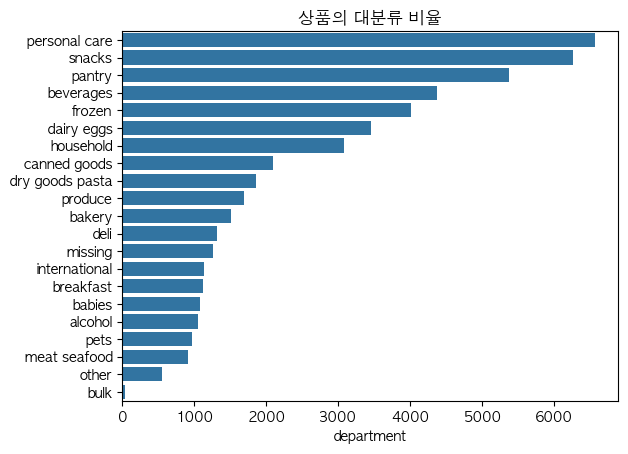

In [18]:
sns.barplot(data=categorized_products['department'].value_counts(), orient='h')
plt.title('상품의 대분류 비율')
plt.show()

### Q. department 중 other 와 bulk 는 무엇일까?

In [19]:
categorized_products.loc[categorized_products['department'] == 'other'].sample(10)

,product_id,product_name,aisle,department
49366,24437,Baby Eczema Therapy Soothing Bath Treatment,other,other
49510,38088,Grenadine Syrup,other,other
49205,11242,for Men Underwear Maximum Absorbency S/M,other,other
49609,46745,Lentil And Rice (Creamy Coconut),other,other
49435,30417,Tolnaftate Powder Spray Antifungal,other,other
49565,43828,Non Alcoholic Lime Margarita Mix,other,other
49350,22396,Digital Pregnancy Test,other,other
49182,8328,Performax Intense Lubricated Ultra Fine Latex ...,other,other
49249,14762,Natural Stress Relief,other,other
49240,14185,Maximum Strength Zinc Oxide Diaper Rash Paste,other,other


In [20]:
categorized_products.loc[categorized_products['department'] == 'bulk'].sample(10)

,product_id,product_name,aisle,department
49654,10915,Organic Short Brown Sprouted Rice,bulk grains rice dried goods,bulk
49650,503,Wild Rice Blend,bulk grains rice dried goods,bulk
49670,43210,Rolled Oats,bulk grains rice dried goods,bulk
49681,14665,Organic White Popcorn,bulk dried fruits vegetables,bulk
49651,6194,Organic Red Kidney Beans,bulk grains rice dried goods,bulk
49679,10540,Whole Medjool Dates,bulk dried fruits vegetables,bulk
49676,1000,Apricots,bulk dried fruits vegetables,bulk
49652,6455,Organic Magic Muesli,bulk grains rice dried goods,bulk
49671,43578,Madagascar Pink Rice,bulk grains rice dried goods,bulk
49668,42091,Pesto Sauce,bulk grains rice dried goods,bulk


## Q. 재구매율이 높은 Product는 무엇인가?

In [21]:
pd_df = pd.merge(left=pd.pivot_table(data=uxp, index='product_id', values=['reorder_ratio', 'mean_add_to_cart_order'], aggfunc='mean').reset_index(), 
         right=categorized_products, on='product_id')
pd_df.head()

,product_id,mean_add_to_cart_order,reorder_ratio,product_name,aisle,department
0,1.0,5.801836,0.613391,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2.0,9.888889,0.133333,All-Seasons Salt,spices seasonings,pantry
2,3.0,6.415162,0.732852,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4.0,9.507599,0.446809,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5.0,6.466667,0.600000,Green Chile Anytime Sauce,marinades meat preparation,pantry


In [22]:
pd_df.sort_values(by='reorder_ratio', ascending=False)[:10]

,product_id,mean_add_to_cart_order,reorder_ratio,product_name,aisle,department
6430,6433.0,2.705882,0.941176,Raw Veggie Wrappers,prepared meals,deli
2074,2075.0,4.793103,0.931034,Serenity Ultimate Extrema Overnight Pads,feminine care,personal care
43545,43553.0,3.538462,0.923077,Orange Energy Shots,energy sports drinks,beverages
27734,27740.0,3.702970,0.920792,Chocolate Love Bar,candy chocolate,snacks
14605,14609.0,1.514286,0.914286,Soy Powder Infant Formula,baby food formula,babies
13871,13875.0,3.200000,0.911111,Simply Sleep Nighttime Sleep Aid,other,other
39984,39992.0,5.363636,0.909091,"Energy Shot, Grape Flavor",energy sports drinks,beverages
31412,31418.0,3.883333,0.900000,Sparking Water,water seltzer sparkling water,beverages
35598,35604.0,4.570000,0.900000,Maca Buttercups,candy chocolate,snacks
5865,5868.0,2.333333,0.900000,Russian River Valley Reserve Pinot Noir,red wines,alcohol


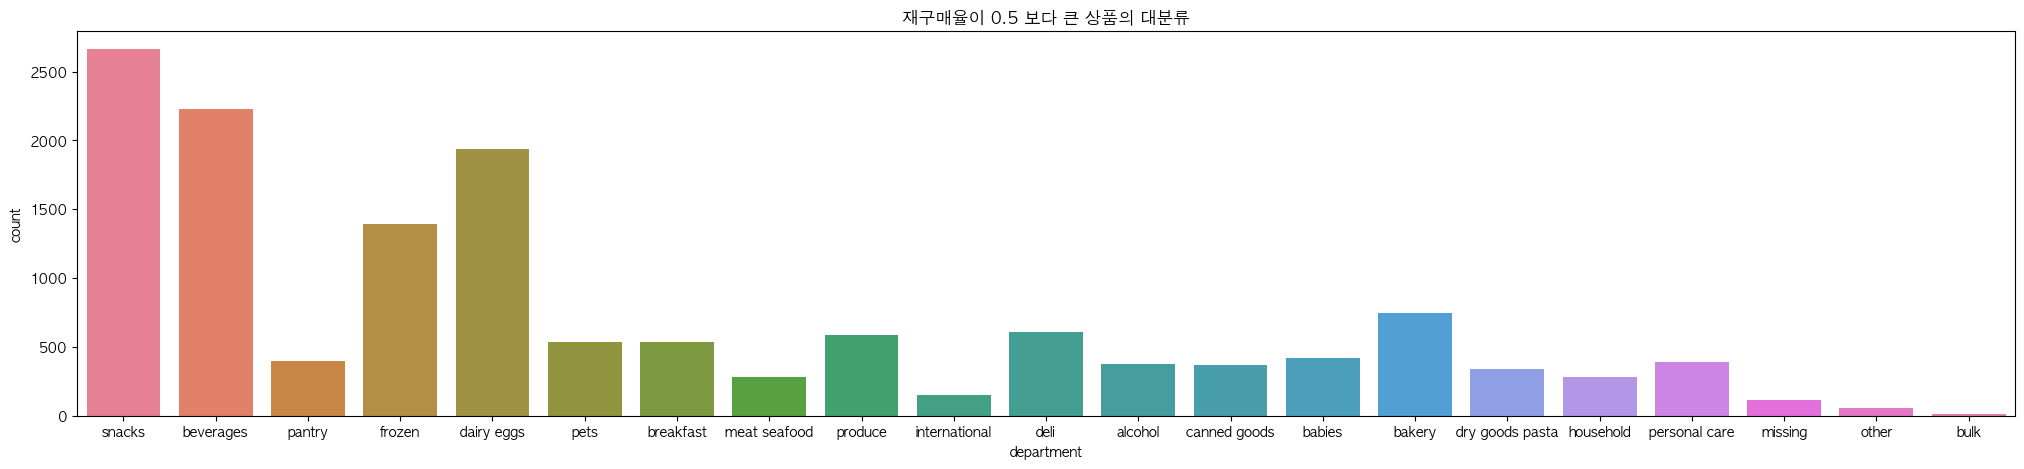

In [23]:
plt.figure(figsize=(25, 5))
sns.countplot(data=pd_df.loc[pd_df['reorder_ratio'] > 0.5], x='department', hue='department')
plt.title('재구매율이 0.5 보다 큰 상품의 대분류')
plt.show()

## Q. 카트에 가장 먼저 담겼던 제품은?

In [24]:
pd_df.loc[pd_df['mean_add_to_cart_order'] == 1]

,product_id,mean_add_to_cart_order,reorder_ratio,product_name,aisle,department
2768,2769.0,1.0,0.0,Pappardelle Nests Pasta,dry pasta,dry goods pasta
2795,2796.0,1.0,0.0,American Blend,hot cereal pancake mixes,breakfast
3830,3833.0,1.0,0.0,Quart Bags,food storage,household
11250,11254.0,1.0,0.0,Drink Distinct All Natural Soda Pineapple Coco...,missing,missing
12837,12841.0,1.0,0.0,King Crab Legs,seafood counter,meat seafood
25436,25441.0,1.0,0.0,Spicy Falafel,missing,missing
25883,25888.0,1.0,0.0,Super Nutrition Vanilla Shake,vitamins supplements,personal care
27857,27863.0,1.0,0.0,Cooking Fuel,kitchen supplies,household
30337,30343.0,1.0,0.0,Seltzer Blueberry Lemonade,missing,missing
33434,33440.0,1.0,0.0,Rosa Mosqueta Rose Hip Seed Oil,skin care,personal care


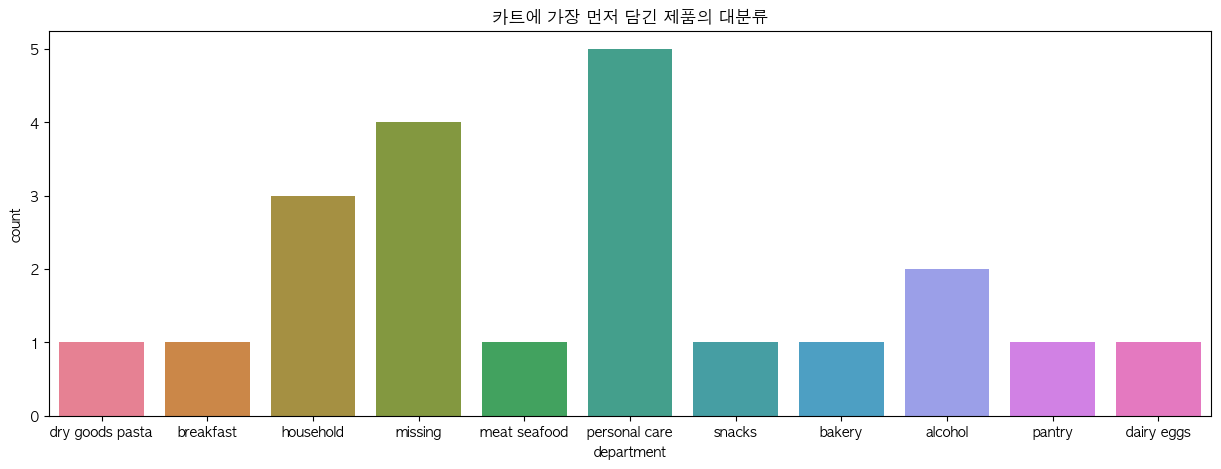

In [25]:
plt.figure(figsize=(15, 5))
sns.countplot(data=pd_df.loc[pd_df['mean_add_to_cart_order'] == 1], x='department', hue='department')
plt.title('카트에 가장 먼저 담긴 제품의 대분류')
plt.show()

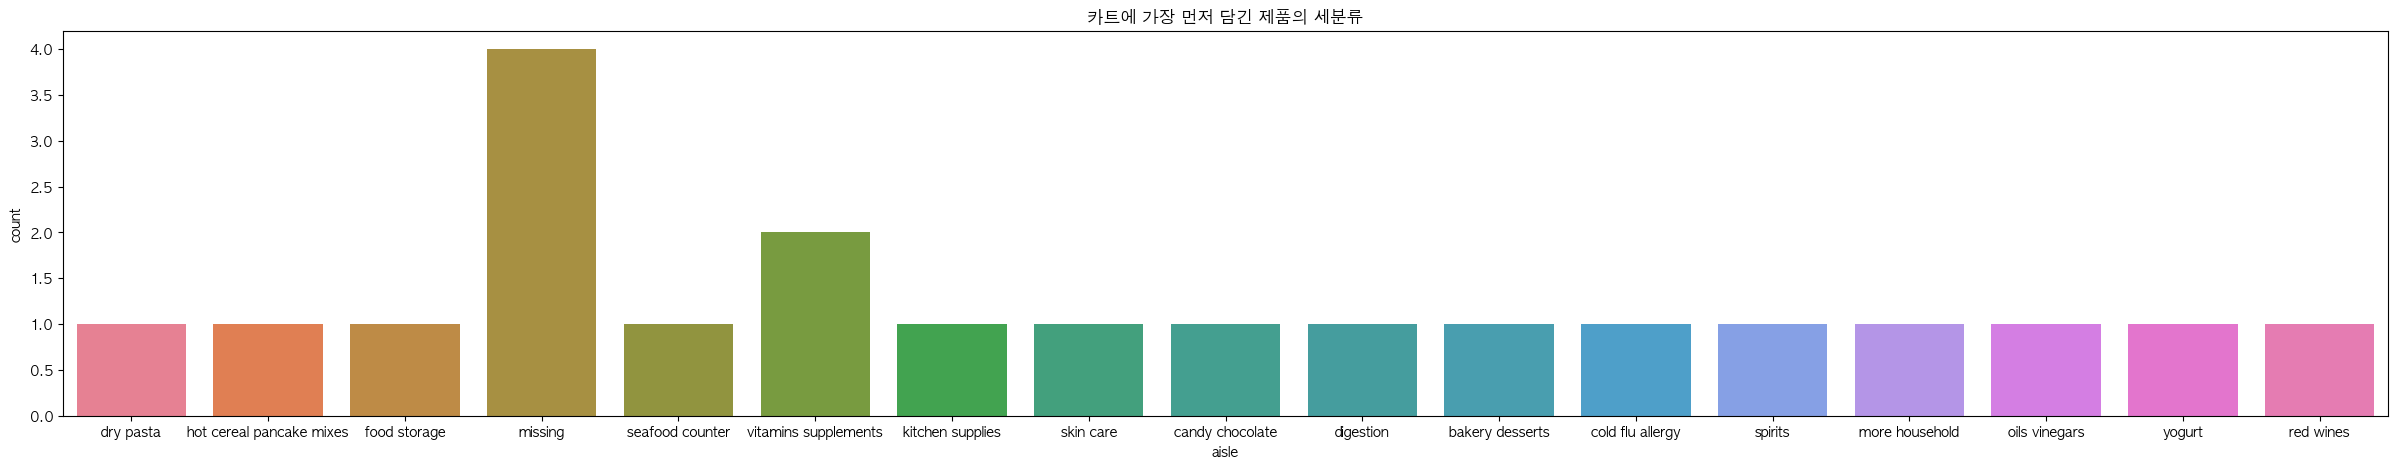

In [26]:
plt.figure(figsize=(30, 5))
sns.countplot(data=pd_df.loc[pd_df['mean_add_to_cart_order'] == 1], x='aisle', hue='aisle')
plt.title('카트에 가장 먼저 담긴 제품의 세분류')
plt.show()

In [27]:
del pd_df

# Modeling

In [28]:
merged_uxp_train_test_orders = pd.merge(left=uxp,
                                        right=orders_train_test, 
                                        on='user_id', 
                                        how='left')
merged_uxp_train_test_orders.head()

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,196.0,10,0.417500,4.0,0.8,11,1,0.776480,3.721774,5.363636,1187899,train,11,4,8,14.0
1,1,10258.0,9,0.447038,4.0,0.8,11,2,0.713772,4.277492,5.363636,1187899,train,11,4,8,14.0
2,1,10326.0,1,0.478419,0.0,0.0,11,5,0.652009,4.191097,5.363636,1187899,train,11,4,8,14.0
3,1,12427.0,10,0.470518,4.0,0.8,11,1,0.740735,4.760037,5.363636,1187899,train,11,4,8,14.0
4,1,13032.0,3,0.520218,2.0,0.4,11,2,0.657158,5.622767,5.363636,1187899,train,11,4,8,14.0


In [29]:
uxp_train = pd.merge(
    left=merged_uxp_train_test_orders.loc[merged_uxp_train_test_orders['eval_set'] == 'train'], 
    right=train, 
    on=['product_id', 'order_id'], 
    how='left').drop(columns=['order_id','eval_set', 'add_to_cart_order'])

uxp_train.head()

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196.0,10,0.417500,4.0,0.8,11,1,0.776480,3.721774,5.363636,11,4,8,14.0,1.0
1,1,10258.0,9,0.447038,4.0,0.8,11,2,0.713772,4.277492,5.363636,11,4,8,14.0,1.0
2,1,10326.0,1,0.478419,0.0,0.0,11,5,0.652009,4.191097,5.363636,11,4,8,14.0,NaN
3,1,12427.0,10,0.470518,4.0,0.8,11,1,0.740735,4.760037,5.363636,11,4,8,14.0,NaN
4,1,13032.0,3,0.520218,2.0,0.4,11,2,0.657158,5.622767,5.363636,11,4,8,14.0,1.0


In [30]:
uxp_test = merged_uxp_train_test_orders.loc[merged_uxp_train_test_orders['eval_set'] == 'test'].drop(columns=['eval_set', 'order_id'])
uxp_test.head()

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5,times_last5_ratio,total_orders,first_order_number,reorder_ratio,mean_add_to_cart_order,order_size_avg,order_number,order_dow,order_hour_of_day,days_since_prior_order
120,3,248.0,1,0.720492,0.0,0.0,13,2,0.400251,10.620782,6.769231,13,5,15,11.0
121,3,1005.0,1,0.687259,1.0,0.2,13,10,0.440605,9.498920,6.769231,13,5,15,11.0
122,3,1819.0,3,0.653128,0.0,0.0,13,4,0.492162,9.287541,6.769231,13,5,15,11.0
123,3,7503.0,1,0.616269,0.0,0.0,13,3,0.553551,9.547379,6.769231,13,5,15,11.0
124,3,8021.0,1,0.559164,0.0,0.0,13,2,0.591157,8.822854,6.769231,13,5,15,11.0


In [31]:
del [uxp, merged_uxp_train_test_orders]

In [32]:
uxp_train = uxp_train.set_index(['user_id', 'product_id'])
uxp_train['reordered'] = uxp_train['reordered'].fillna(0)
uxp_test = uxp_test.set_index(['user_id', 'product_id'])

In [33]:
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

## X, y 변수 정리

In [35]:
X = uxp_train.drop(columns=['reordered'])
y = uxp_train['reordered']

print("X_train.shape:", X.shape)
print("y_train.shape", y.shape)
print(y.value_counts())

X_train.shape: (8474661, 13)
y_train.shape (8474661,)
0.0    7645837
1.0     828824
Name: reordered, dtype: int64


## 데이터 정규화

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(uxp_test)

## 모델 학습

In [36]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.76,
    'bagging_fraction': 0.75,
    'bagging_freq': 5
}
ROUNDS = 50

print('light GBM train :-)')
model = lgb.train(params, lgb.Dataset(X_scaled, label=y), ROUNDS)

light GBM train :-)
[LightGBM] [Info] Number of positive: 828824, number of negative: 7645837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1455
[LightGBM] [Info] Number of data points in the train set: 8474661, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

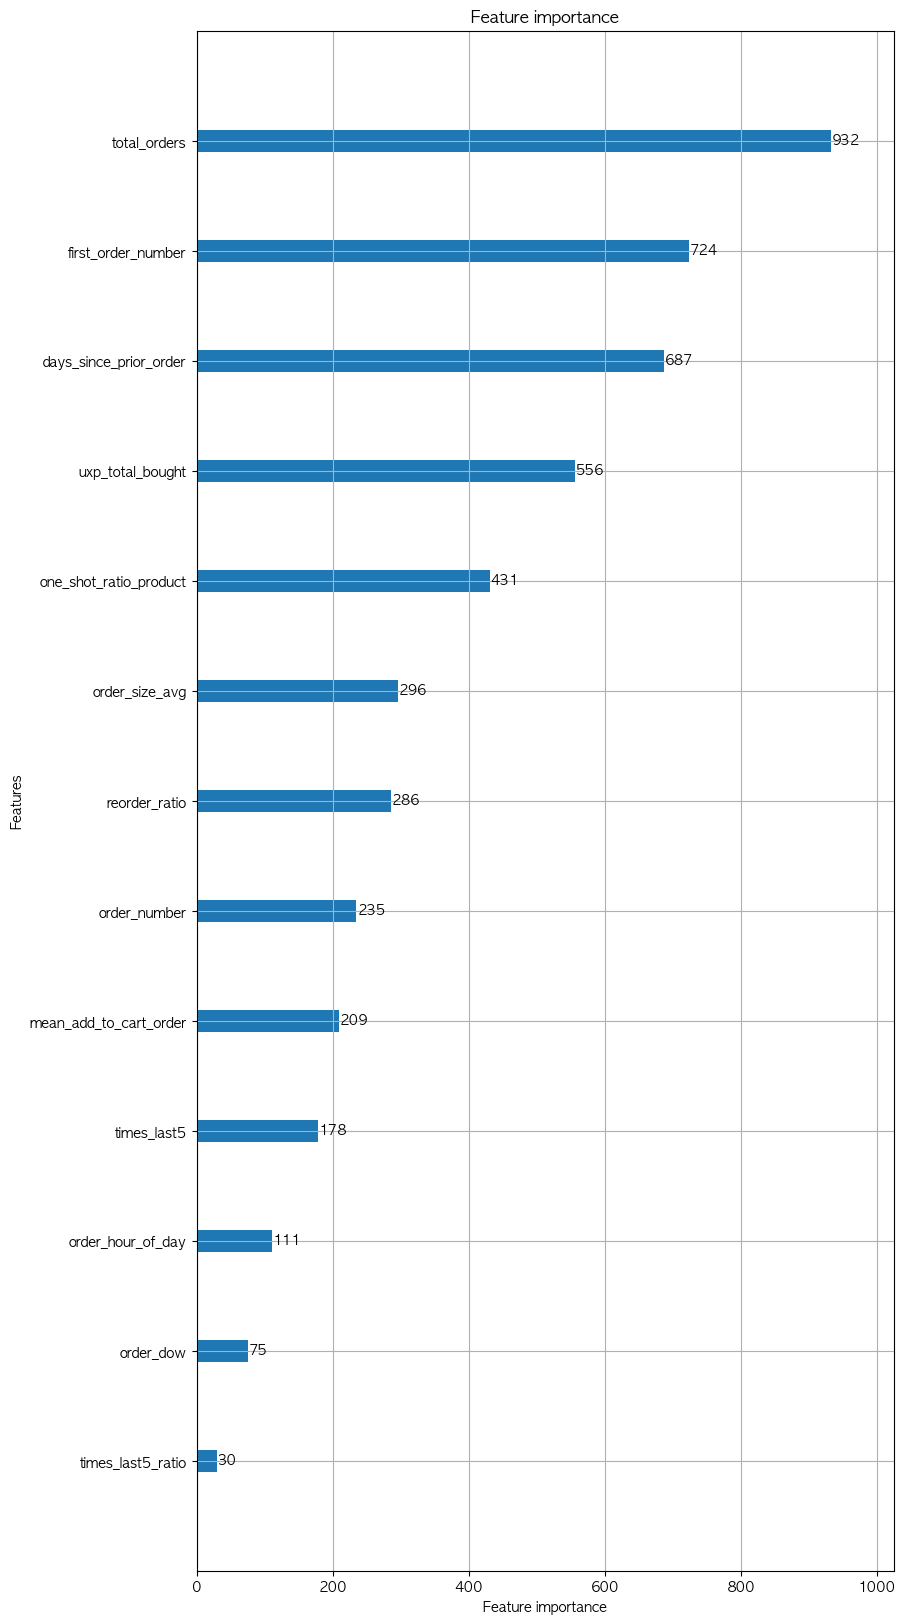

In [37]:
lgb.plot_importance(model, figsize=(9, 20))

## Test Data Set 얘측 확인

In [38]:
uxp_test["reordered"] = model.predict(X_test_scaled)

## 제출파일 생성

In [39]:
uxp_test = uxp_test.reset_index()
uxp_test = uxp_test[['product_id', 'user_id', "reordered"]]

In [40]:
orders_test = orders_train_test.loc[orders_train_test['eval_set'] == 'test']

In [41]:
uxp_test = uxp_test.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left').drop('user_id', axis=1)
uxp_test.columns = ['product_id', 'prediction', 'order_id']
uxp_test.product_id = uxp_test.product_id.astype(int)
uxp_test.order_id = uxp_test.order_id.astype(int)
uxp_test.head()

,product_id,prediction,order_id
0,248,0.018064,2774568
1,1005,0.050195,2774568
2,1819,0.073401,2774568
3,7503,0.026840,2774568
4,8021,0.028030,2774568


In [42]:
del orders_train_test
del orders_test

In [43]:
import numpy as np
from operator import itemgetter

class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)


def get_best_prediction(items, preds, pNone=None):
#    print("Maximize F1-Expectation")
#    print("=" * 23)
    items_preds = sorted(list(zip(items, preds)), key=itemgetter(1), reverse=True)
    P = [p for i,p in items_preds]
    L = [i for i,p in items_preds]
    
    opt = F1Optimizer.maximize_expectation(P)
    best_prediction = []
    best_prediction += (L[:opt[0]])
    if best_prediction == []:
        best_prediction = ['None']
            
#    print("Prediction {} yields best E[F1] of {}\n".format(best_prediction, f1_max))
    return ' '.join(list(map(str,best_prediction)))

In [51]:
import pandas as pd
import multiprocessing as mp
import time

#==============================================================================
# load
#==============================================================================
sub_item = uxp_test.groupby(['order_id','product_id']).prediction.mean().reset_index()
sub = sub_item.groupby('order_id').product_id.apply(list).to_frame()
sub['yhat'] = sub_item.groupby('order_id').prediction.apply(list)
sub.reset_index(inplace=True)

del uxp_test, sub_item

def multi(i):
    if i%1000==0:
        print('{:.3f} min'.format((time.time()-st_time)/60))
    items = sub.loc[i,'product_id']
    preds = sub.loc[i,'yhat']
    ret = get_best_prediction(items, preds)
    return ret

st_time = time.time()
pool = mp.Pool(4)
callback = pool.map(multi, range(sub.shape[0]))

sub['products'] = callback
sub.head()

In [ ]:
sub.reset_index(inplace=True)
sub = sub[['order_id', 'products']]

In [ ]:
'''sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
'''

print(sub.shape[0])
print(sub.shape[0]==75000)

sub.to_csv('submission.csv', index=False)